In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
start_date = datetime.datetime(2005, 2, 1)
end_date = datetime.datetime(2020, 3, 30)

In [3]:
def date_filter(df):
    return df.loc[(df.index >= start_date) & (df.index <= end_date)]

In [4]:
def load_weather_data():
    df = pd.read_csv('../data/central_park_weather_data.csv', dtype='object')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['weekday'] = df.DATE.dt.weekday
    df['week'] = df.DATE.dt.week
    df['month'] = df.DATE.dt.month
    df['year'] = df.DATE.dt.year
    df = df[df.DATE >= '20010101']
    df['TMAX'] = df['TMAX'].astype('float')
    df['TMIN'] = df['TMIN'].astype('float')
    df['PRCP'] = df['PRCP'].astype('float')
    return df[[
        'weekday', 
        'week', 
        'month', 
        'PRCP',
        'TMAX',
        'TMIN',
        'DATE',
    ]].set_index('DATE').sort_index()

In [5]:
weather_data = load_weather_data()

In [6]:
def load_pal_data():
    df = pd.read_csv('../data/nyiso_pal_master.csv')
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    return df[[
        'Time Stamp',
        'min',
        'max',
        'mean',
    ]].set_index('Time Stamp').sort_index().rename(columns={'min': 'pal_min', 'max': 'pal_max', 'mean': 'pal_mean'})

In [7]:
weather_data = date_filter(weather_data)
actual_load = load_pal_data()
actual_load = date_filter(actual_load)
print(weather_data.head())
print(weather_data.tail())
print(actual_load.head())
print(actual_load.tail())
print(weather_data.shape)
print(actual_load.shape)

            weekday  week  month  PRCP  TMAX  TMIN
DATE                                              
2005-02-01        1     5      2  0.00  40.0  25.0
2005-02-02        2     5      2  0.00  40.0  28.0
2005-02-03        3     5      2  0.02  41.0  29.0
2005-02-04        4     5      2  0.27  46.0  34.0
2005-02-05        5     5      2  0.00  53.0  38.0
            weekday  week  month  PRCP  TMAX  TMIN
DATE                                              
2020-03-26        3    13      3  0.00  60.0  38.0
2020-03-27        4    13      3  0.00  69.0  50.0
2020-03-28        5    13      3  0.45  54.0  44.0
2020-03-29        6    13      3  0.05  47.0  44.0
2020-03-30        0    14      3  0.04  52.0  41.0
            pal_min  pal_max     pal_mean
Time Stamp                               
2005-02-01      0.0   7154.7  5580.662630
2005-02-02      0.0   7153.9  5535.835517
2005-02-03      0.0   7152.1  5514.954639
2005-02-04      0.0   6890.1  5717.773469
2005-02-05   4299.9   5990.4  5130

In [15]:
merged = actual_load.join(weather_data, how='inner')
print(merged.head())
print(merged.shape)

            pal_min  pal_max     pal_mean  weekday  week  month  PRCP  TMAX  \
2005-02-01      0.0   7154.7  5580.662630        1     5      2  0.00  40.0   
2005-02-02      0.0   7153.9  5535.835517        2     5      2  0.00  40.0   
2005-02-03      0.0   7152.1  5514.954639        3     5      2  0.02  41.0   
2005-02-04      0.0   6890.1  5717.773469        4     5      2  0.27  46.0   
2005-02-05   4299.9   5990.4  5130.559122        5     5      2  0.00  53.0   

            TMIN  
2005-02-01  25.0  
2005-02-02  28.0  
2005-02-03  29.0  
2005-02-04  34.0  
2005-02-05  38.0  
(5513, 9)


In [19]:
merged.isnull().values.any()

False

In [23]:
merged = merged.drop(columns=['pal_min', 'pal_max'])

In [24]:
merged = merged.sample(frac=1).reset_index(drop=True)
merged.head()

,pal_mean,weekday,week,month,PRCP,TMAX,TMIN
0,5572.271821,5,11,3,0.03,38.0,25.0
1,5505.481724,3,45,11,0.00,55.0,39.0
2,5372.493056,5,3,1,0.07,41.0,29.0
3,5116.046713,5,48,11,0.00,50.0,42.0
4,5609.457785,2,52,12,1.55,64.0,52.0


Now, we will normalize the data

In [25]:
mean = merged.mean(axis=0)
merged -= mean
std = merged.std(axis=0)
merged /= std
merged.head()

,pal_mean,weekday,week,month,PRCP,TMAX,TMIN
0,-0.547556,1.000318,-1.021544,-1.009380,-0.280993,-1.377508,-1.433024
1,-0.616546,0.000181,1.230980,1.303348,-0.355005,-0.442370,-0.590618
2,-0.753915,1.000318,-1.551550,-1.587562,-0.182311,-1.212484,-1.192336
3,-1.018808,1.000318,1.429732,1.303348,-0.355005,-0.717411,-0.410103
4,-0.509145,-0.499887,1.694735,1.592439,3.468934,0.052703,0.191616


In [33]:
train_df = merged.sample(frac=0.8)
labels = train_df['pal_mean'].tolist()
train_df.drop(columns=['pal_mean'], inplace=True)
train_df.head()

,weekday,week,month,PRCP,TMAX,TMIN
482,-0.999955,0.767225,0.725166,-0.355005,0.712801,0.793334
102,0.500249,-0.955294,-1.009380,-0.009617,-0.607394,-0.891477
668,0.500249,-1.617801,-1.587562,-0.355005,-0.662403,-0.891477
4179,1.500386,-0.027784,-0.142107,-0.355005,1.097858,1.154365
1102,0.000181,-0.226536,-0.142107,0.977206,0.272736,0.372131


In [40]:
main_input = Input(shape=(train_df.shape[1],), name='main_input')

x = Dense(64, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                448       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train_df], labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3528 samples, validate on 882 samples
Epoch 1/50
3528/3528 [==============================] - 1s 354us/step - loss: 0.3221 - mean_absolute_error: 0.4293 - val_loss: 0.1333 - val_mean_absolute_error: 0.2646
Epoch 2/50
3528/3528 [==============================] - 0s 113us/step - loss: 0.1628 - mean_absolute_error: 0.2959 - val_loss: 0.1077 - val_mean_absolute_error: 0.2429
Epoch 3/50
3528/3528 [==============================] - 0s 115us/step - loss: 0.1386 - mean_absolute_error: 0.2735 - val_loss: 0.0965 - val_mean_absolute_error: 0.2318
Epoch 4/50
3528/3528 [==============================] - 0s 112us/step - loss: 0.1355 - mean_absolute_error: 0.2701 - val_loss: 0.0942 - val_mean_absolute_error: 0.2264
Epoch 5/50
3528/3528 [==============================] - 0s 113us/step - loss: 0.1259 - mean_absolute_error: 0.2597 - val_loss: 0.0985 - val_mean_absolute_error: 0.2222
Epoch 6/50
3528/3528 [==============================] - 0s 114us/step - loss: 0.1180 - mean_absolute_error: 0.247

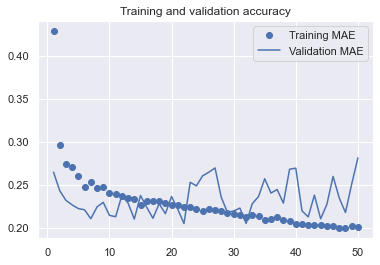

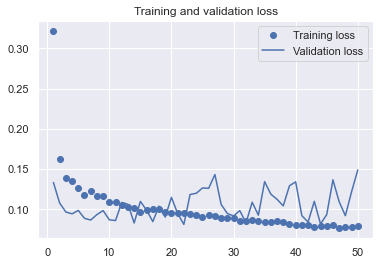

In [52]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()